 <h1><center>IBD</center></h1>

<center>The purpose of this notebook is to export plink files given a file of samples and vcfs.</center>


## Load Hail and Python Modules

In [3]:
import hail as hl
import hail.expr.aggregators as agg
hl.init()

Running on Apache Spark version 2.2.0
SparkUI available at http://10.128.0.19:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version devel-c3bd118
NOTE: This is a beta version. Interfaces may change
  during the beta period. We also recommend pulling
  the latest changes weekly.


Load python modules

NOTE: How do u install other python modules?

In [9]:
import numpy as np
import re
import logging
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter, defaultdict
from os.path import basename, splitext
from math import log, isnan
from pprint import pprint
%matplotlib inline
logging.basicConfig(level=logging.INFO, format='%(asctime)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

## Maintain Dictionary of Translated VCF Locations
NOTE: Or store maintained locations in a text file

remove test dictionary later!!!!

In [10]:
vcf_locations={"/seq/dax/CMG_MYOSEQ/Exome/v4/CMG_MYOSEQ.vcf.gz":"gs://seqr-datasets/GRCh37/cmg_sankaran_wes/CMG_MYOSEQ.vcf.gz",
"https://portal.firecloud.org/#workspaces/broad-genomics-data/CMG_RGP_Broad_MacArthur_RareDisease_WGS_Callsets_v2/data":"gs://seqr-datasets/GRCh38/cmg_chung_wgs_sep2017/CMG_RGP_Broad_MacArthur_RareDisease_WGS_Callsets_v2.vcf.gz"
}

## Prep Sample List
Generate dictionary where keys are unique vcfs and values are a list a samples you want subsetted from that vcf

In [11]:
infile="gs://seqr-dbgap/ibd_mar2018.txt"
OUT_MISSING=hl.hadoop_open("gs://seqr-dbgap/test/missing_vcfs.txt",'w')
OUT_INCLUDED=hl.hadoop_open("gs://seqr-dbgap/test/included_vcfs.txt",'w')
samples=defaultdict(list)

with hl.hadoop_open(infile,'r') as IN:
    next(IN) #skip header
    for line in IN:
        line=line.rstrip()
        items=line.split('\t')
        subject,sample,sample_type,vcf=items[0:4]
        if sample !=".":
            if vcf==".":
                OUT_MISSING.write(line + '\n') # write samples that don't have a vcf path
            else:
                vcf_location=vcf_locations[vcf]
                samples[vcf_location].append(sample) # write samples that will be processed
                OUT_INCLUDED.write(line + '\n')

OUT_MISSING.close()
OUT_INCLUDED.close()

## Use Test Dataset---REMOVE LATER

In [12]:
samples=defaultdict(list)
#samples["MAN_0753_01"].append("MAN_0753_01")
#samples["MAN_0753_02"].append("MAN_0753_02")
#samples["MAN_0753_03"].append("MAN_0753_03")

samples["gs://seqr-dbgap/subsetted_test2.vcf.gz"].append("MAN_0753_01_1")
samples["gs://seqr-dbgap/subsetted_test3.vcf.gz"].append("MAN_0753_02_1")
samples["gs://seqr-dbgap/subsetted_test4.vcf.gz"].append("MAN_0753_03_1")

vcf_locations={"MAN_0753_01_1":"gs://seqr-dbgap/subsetted_test2.mt",
               "MAN_0753_02_1":"gs://seqr-dbgap/subsetted_test3.mt",
               "MAN_0753_03_1":"gs://seqr-dbgap/subsetted_test4.mt"
              }

## Functions
Fucntions to
1) read in a vcf and write out a matrix table and 
2) to read in and join two matrix tables then count the number of variants in the resulting merged mt

NOTE: Add in a check for GRCH 38?

In [13]:
def generate_mt(vcf,outpath):
    # pull basename:
    file=basename(vcf)
    file_name=splitext(file)[0]
    logging.info("Generating matrix table for {file}...".format(**locals())) # would be nice to print this to a file but don't know how
    
    # import vcf and write vds
    hl.import_vcf(vcf,force_bgz=True,reference_genome="GRCh38",min_partitions=4).write("{outpath}/{file_name}.mt".format(**locals()), overwrite=True)

def join_mt(input_vcf,sample_keep_list,outpath,first):
    file=basename(input_vcf)
    file_name=splitext(file)[0]
    file_name=re.sub(".vcf","",file_name)
    input_mt=outpath+"/"+file_name+".mt"
    logging.info("Subsetting and merging in {input_mt}...".format(**locals()))

    
    mt = hl.read_matrix_table(input_mt)
    
    # subset to samples given in the list
    set_to_keep = hl.literal(sample_keep_list)
    mt_subset= mt.filter_cols(set_to_keep.contains(mt['s']))

    # filter to SNV and biallelics
    snv_mt = mt_subset.filter_rows((hl.len(mt_subset.alleles) == 2) & hl.is_snp(mt_subset.alleles[0], mt_subset.alleles[1]))
    
    # merge the matrix tables
    if first==True:
        temp_merged_mt = snv_mt
    else:
        temp_merged_mt = merged_mt.union_cols(snv_mt)
      
    # print log info
    starting_rows=mt.count_rows()
    merged_rows=temp_merged_mt.count_rows()
    merged_cols=temp_merged_mt.count_cols()
    OUT_LOG.write("Rows in input file {input_mt}: {starting_rows}\n".format(**locals()))
    OUT_LOG.write("Rows in merged mt: {merged_rows}\n".format(**locals()))
    OUT_LOG.write("Samples in merged mt: {merged_cols}\n\n".format(**locals()))

    print("MERGE COMPLETE")
    return temp_merged_mt

## Generate and Join Matrix Tables

In [12]:
# can add in a if exists VDS step but that won't account for version issues
# union_col act as an inner join
# better to test a subset of cols or a subset or rows

## Generate Matrix Table

In [16]:
OUT_LOG=hl.hadoop_open("gs://seqr-dbgap/test/log_progress.txt",'w')
outdir="gs://seqr-dbgap"
make_mt=False # set to False if the mt already exists and want to skip this step

#comment out in new cell
if make_mt==True:
    for vcf in samples:
        print(vcf)
        samples_to_subset=samples[vcf]
        if make_mt==True:
            generate_mt(vcf,outdir)

## Join Matrix Table

In [17]:
first=True
for vcf in samples:
    samples_to_subset=samples[vcf]
    merged_mt=join_mt(vcf,samples_to_subset,outdir,first)
    first=False # after first mt has been processed, set first to false

04/05/2018 06:41:35 PM: Subsetting and merging in gs://seqr-dbgap/subsetted_test2.mt...
04/05/2018 06:42:27 PM: Subsetting and merging in gs://seqr-dbgap/subsetted_test3.mt...


MERGE COMPLETE


04/05/2018 06:45:18 PM: Subsetting and merging in gs://seqr-dbgap/subsetted_test4.mt...


MERGE COMPLETE
MERGE COMPLETE


In [ ]:
#mm=hl.read_matrix_table("gs://seqr-dbgap/subsetted_test5.mt")

## Check the Data

In [19]:
mm=merged_mt

In [15]:
mm.count_rows()

7817182

In [35]:
mm.count_cols()

3

In [17]:
mm.rows().select('locus', 'alleles').show(5)

+---------------+------------+
| locus         | alleles    |
+---------------+------------+
| locus<GRCh38> | array<str> |
+---------------+------------+
| chr1:10492    | ["C","T"]  |
| chr1:10622    | ["T","G"]  |
| chr1:10623    | ["T","C"]  |
| chr1:10904    | ["G","A"]  |
| chr1:10927    | ["A","G"]  |
+---------------+------------+
showing top 5 rows



Here is how to peek at the first few sample IDs:

In [18]:
mm.s.show(10)

+---------------+
| s             |
+---------------+
| str           |
+---------------+
| MAN_0753_01_1 |
| MAN_0753_02_1 |
| MAN_0753_03_1 |
+---------------+



To look at the first few genotype calls, we can use [entries](https://hail.is/docs/devel/hail.MatrixTable.html#hail.MatrixTable.entries) along with `select` and `take`. The `take` method collects the first n rows into a list. Alternatively, we can use the `show` method, which prints the first n rows to the console in a table format. 
|
Try changing `take` to `show` in the cell below.

In [19]:
mm.entry.take(5)

[Struct(AD=[7, 3], DP=10, GQ=56, GT=0/1, MIN_DP=None, PGT=None, PID=None, PL=[56, 0, 138], RGQ=None, SB=None),
 Struct(AD=[17, 0], DP=17, GQ=51, GT=0/0, MIN_DP=None, PGT=None, PID=None, PL=[0, 51, 571], RGQ=None, SB=None),
 Struct(AD=[5, 3], DP=8, GQ=80, GT=0/1, MIN_DP=None, PGT=None, PID=None, PL=[80, 0, 127], RGQ=None, SB=None),
 Struct(AD=[0, 2], DP=2, GQ=9, GT=1/1, MIN_DP=None, PGT=['1|1'], PID=['10622_T_G'], PL=[100, 9, 0], RGQ=None, SB=None),
 Struct(AD=[3, 0], DP=3, GQ=None, GT=None, MIN_DP=None, PGT=None, PID=None, PL=[0, 0, 0], RGQ=None, SB=None)]

In [44]:
mm.entry.show(5)

+---------------+----------------+----------------+--------------+-----------+
| locus         | alleles        | s              | <expr>.AD    | <expr>.DP |
+---------------+----------------+----------------+--------------+-----------+
| locus<GRCh38> | array<str>     | str            | array<int32> |     int32 |
+---------------+----------------+----------------+--------------+-----------+
| chr1:10109    | ["AACCCT","A"] | MAN_0063_01_01 | [69,0]       |        69 |
| chr1:10109    | ["AACCCT","A"] | MAN_0510_01_1  | [89,0]       |        89 |
| chr1:10109    | ["AACCCT","A"] | MAN_0510_02_1  | [74,0]       |        74 |
| chr1:10109    | ["AACCCT","A"] | MAN_0510_03_1  | [87,0]       |        87 |
| chr1:10109    | ["AACCCT","A"] | MAN_0753_01_1  | [64,0]       |        64 |
+---------------+----------------+----------------+--------------+-----------+

+-----------+-----------+---------------+------------+------------+--------------+
| <expr>.GQ | <expr>.GT | <expr>.MIN_DP | <expr

In [20]:
mm.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQRankSum: float64, 
        NEGATIVE_TRAIN_SITE: bool, 
        POSITIVE_TRAIN_SITE: bool, 
        QD: float64, 
        RAW_MQ: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        culprit: str
    } 
----------------------------------------

## Filter to SNVs and Biallelics
Need a filter step here to make sure merging the matrix tables didn't not generate any new multiallelic sites

In [21]:
mm = mm.filter_rows((hl.len(mm.alleles) == 2) & hl.is_snp(mm.alleles[0], mm.alleles[1]))

In [22]:
#Count variants checkpoint
num_rows=mm.count_rows()
logging.info("Filtering to SNVs and biallelics")
OUT_LOG.write("Rows after SNV/biallelic filter: {num_rows}...\n\n".format(**locals()))

04/04/2018 07:39:58 PM: Filtering to SNVs and biallelics


45

## LD Prune Results
SET R2?, 

WHEN TO WRITE OUT NEW MT, 

how to decide ncores,

what is window

In [23]:
mm = hl.methods.ld_prune(mm,5,r2=0.1, window=1000000,memory_per_core=256)

2018-04-04 19:42:43 Hail: INFO: Running LD prune with nSamples=3, nVariants=7817182, nPartitions=10, and maxQueueSize=1315861.
2018-04-04 19:44:55 Hail: INFO: LD prune step 1 of 3: nVariantsKept=4873, nPartitions=10, time=2m12.6s
2018-04-04 19:44:57 Hail: INFO: LD prune step 2 of 3: nVariantsKept=4861, nPartitions=15, time=1.711s
2018-04-04 19:44:58 Hail: INFO: LD prune step 3 of 3: nVariantsKept=4861, time=794.468ms


In [24]:
#Count variants checkpoint
num_rows=mm.count_rows()
logging.info("LD prunning...")
OUT_LOG.write("Rows after LD pruning: {num_rows}...\n\n".format(**locals()))

04/04/2018 07:48:05 PM: LD prunning...


32

## Recompute AF
NOTE: should this be in it's own column or replace the INFO field

In [25]:
mm = mm.annotate_rows(ac = hl.agg.sum(mm.GT.n_alt_alleles()),
                                an=2 * hl.agg.count_where(hl.is_defined(mm.GT)))

In [26]:
mm = mm.annotate_rows(af=mm.ac/mm.an)

In [27]:
mm.describe()
mm.count_cols()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh38> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        AC: array<int32>, 
        AF: array<float64>, 
        AN: int32, 
        BaseQRankSum: float64, 
        ClippingRankSum: float64, 
        DB: bool, 
        DP: int32, 
        END: int32, 
        ExcessHet: float64, 
        FS: float64, 
        InbreedingCoeff: float64, 
        MLEAC: array<int32>, 
        MLEAF: array<float64>, 
        MQ: float64, 
        MQRankSum: float64, 
        NEGATIVE_TRAIN_SITE: bool, 
        POSITIVE_TRAIN_SITE: bool, 
        QD: float64, 
        RAW_MQ: float64, 
        ReadPosRankSum: float64, 
        SOR: float64, 
        VQSLOD: float64, 
        culprit: str
    } 
    'ac': int32 
    'an': int64 
    'a

3

In [28]:
mm.head(3)
OUT_LOG.close()

## Plot AF
Generate a histogram plot of population allele frequencies

In [29]:
df = mm.rows().to_pandas()
df.head()

,locus.contig,locus.position,alleles,rsid,qual,filters,info.AC,info.AF,info.AN,info.BaseQRankSum,...,info.POSITIVE_TRAIN_SITE,info.QD,info.RAW_MQ,info.ReadPosRankSum,info.SOR,info.VQSLOD,info.culprit,ac,an,af
0,chr1,10492,"[C, T]",rs55998931,1054.11,[VQSRTrancheSNP99.90to100.00+],[2],[0.143],14,-0.118,...,None,4.47,None,0.000,0.842,-5.619,QD,2,6,0.333333
1,chr1,10622,"[T, G]",None,2729.00,[VQSRTrancheSNP99.90to100.00+],[4],[0.5],8,1.060,...,None,11.05,None,-0.736,3.702,-227.300,FS,2,4,0.500000
2,chr1,1021618,"[C, T]",rs138605419,6282.30,[],[3],[0.214],14,0.689,...,None,15.40,None,0.520,0.690,16.060,DP,3,6,0.500000
3,chr1,1028324,"[C, A]",None,96265.52,[ExcessHet],[8],[0.571],14,-0.692,...,None,16.62,None,0.867,0.650,NaN,None,5,6,0.833333
4,chr1,2028539,"[C, T]",rs28409373,235374.55,[],[6],[0.429],14,0.915,...,True,21.13,None,0.307,0.759,6.820,FS,2,6,0.333333


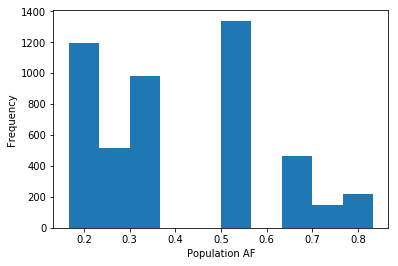

In [30]:
plt.clf()
plt.hist(df["af"])
plt.xlabel("Population AF")
plt.ylabel("Frequency")
plt.show()

## Export Plink Files
don't need to split because already got rid of multiallelics


do we want a better fam ID?


In [33]:
hl.export_plink(mm, 'gs://seqr-dbgap/plink_exports', fam_id = mm.s, id = mm.s)

2018-04-04 20:01:23 Hail: INFO: while writing:
    gs://seqr-dbgap/plink_exports.bed
  merge time: 398.974ms
2018-04-04 20:03:36 Hail: INFO: while writing:
    gs://seqr-dbgap/plink_exports.bim
  merge time: 468.287ms


## Check for Samples Missing from the VCFs

In [54]:
samples_in_mt=set(df2.s) # chould somehow collect here (collect_as_set?) but can't figure out how

In [55]:
print(samples_in_mt)

{'MAN_0753_01_1', 'MAN_0753_03_1', 'MAN_0753_02_1'}


In [56]:
samples2=samples
samples2["fake"].append("fake_sample")

In [71]:
OUT_MISSED_SAMPLES=hl.hadoop_open("gs://seqr-dbgap/test/missing_samples.txt",'w')

for sample_list in samples2.values():
    missings=set(sample_list)-samples_in_mt
    for i in missings:
        OUT_MISSED_SAMPLES.write(i + '\n')
        
OUT_MISSED_SAMPLES.close()

In [ ]:
#check for is defined!